---
layout: single
title: 'Calculating slope and aspect from a digital elevation model in Python'
date: 2016-07-26
authors: [Matt Oakley, Max Joseph]
category: [tutorials]
excerpt: 'This tutorial shows how to compute the slope and aspect from a digital elevation model in Python.'
sidebar:
  nav:
author_profile: false
comments: true
lang: [python]
lib: [matplotlib, numpy, elevation, richdem]
---

Digital elevation models (DEM) provide a representaion of surface topography (elevation) in two dimensional space. DEMs are a 3D representaion of a terrain's surface such as the Earth. Typically, DEM data can be represented as a raster which is most easily expressed as being a 2D array with each individual cell having an elevation associated with it. 

With a DEM, you can analyze certain derived quantities using prebuild software. This tutorial will go over how to compute the **slope** and **aspect** of an area using DEM data.

## Objectives

- Read in DEM data
- Compute the slope for the entirety of the data
- Compute the aspect for the entirety of the data
- Plot the slope of the terrain
- Plot the aspect of the terrain

## Dependencies

- numpy
- matplotlib
- elevation
- richdem

In [1]:
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import elevation
import richdem as rd

In [2]:
matplotlib.rcParams['figure.figsize'] = (8, 5.5)

## Download a digital elevation model

The `elevation` module provides access to elevation data from the NASA SRTM mission, with areas of interest specified via a bounding box. Here you draw a bounding box around Mt. Shasta in northern California, and use the clip funciton to output a GeoTIFF. 

In [3]:
dem_path = os.path.join(os.getcwd(), 'Shasta-30m-DEM.tif')
elevation.clip(bounds=(-122.4, 41.2, -122.1, 41.5), output=dem_path)

## Load the DEM with richdem

The `richdem` package has a `LoadGDAL` function for loading DEMs that you can use here. 

In [4]:
shasta_dem = rd.LoadGDAL(dem_path)

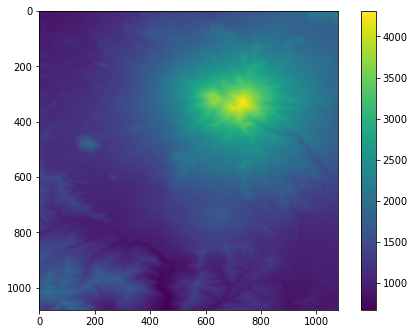

In [5]:
plt.imshow(shasta_dem, interpolation='none')
plt.colorbar()
plt.show()

## Compute and plot slope and aspect

You can use the `rd.TerrainAttribute` function to compute slope and aspect for each pixel. Note that there are multiple ways to represent the slope values. <a href="https://richdem.readthedocs.io/en/latest/python_api.html#richdem.TerrainAttribute" target="_blank">Read the richdem docs for more options.</a>

To visualize slope and aspect, you can use the `rdShow` function. 

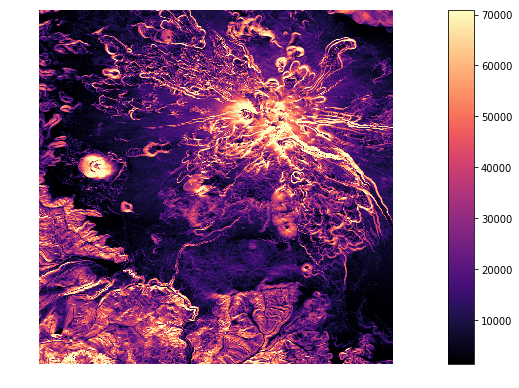

In [6]:
slope = rd.TerrainAttribute(shasta_dem, attrib='slope_riserun')
rd.rdShow(slope, axes=False, cmap='magma', figsize=(8, 5.5))
plt.show()

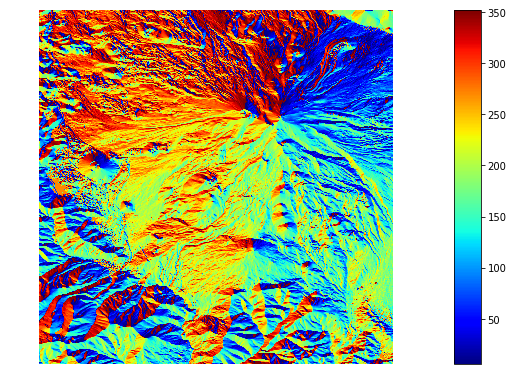

In [7]:
aspect = rd.TerrainAttribute(shasta_dem, attrib='aspect')
rd.rdShow(aspect, axes=False, cmap='jet', figsize=(8, 5.5))
plt.show()